In [1]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_wordvecs, load_all_sum_vectors
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42})
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["DATE_WORDVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

INPUT_FPATH2 = configs["SUM_WORDVEC_PATH"]
print(f"INPUT_FPATH2=={INPUT_FPATH2}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yijingch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yijingch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/date-wordvec-min2-gtm1/
INPUT_FPATH2==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/sum-wordvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [2]:
from src.utils.dict_configuration import dictionary2016, dictionary2020

year = 2016
if year == 2016:
    cand1 = "trump"
    cand2 = "clinton"
    dictionary = dictionary2016
elif year == 2020:
    cand1 = "biden"
    cand2 = "trump"
    dictionary = dictionary2020

Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1426
Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1453


In [3]:
wordvecs_df2016 = load_all_wordvecs(year=2016, wordvec_fpath=INPUT_FPATH)
wordvecs_df2020 = load_all_wordvecs(year=2020, wordvec_fpath=INPUT_FPATH)

sum_wordvecs2016 = load_all_sum_vectors(year=2016, sumvec_fpath=INPUT_FPATH2, vector_type="wordvecs")
sum_wordvecs2020 = load_all_sum_vectors(year=2020, sumvec_fpath=INPUT_FPATH2, vector_type="wordvecs")

# bstr_wordvecs2016 = load_all_sum_vectors(year=2016, sumvec_fpath=INPUT_FPATH, vector_type="wordvecs", load_bstr=True)
# bstr_wordvecs2020 = load_all_sum_vectors(year=2020, sumvec_fpath=INPUT_FPATH, vector_type="wordvecs", load_bstr=True)

In [4]:
# LOAD EVENTS 
events = pd.read_csv(ROOTPATH + "index/events.tsv", sep="\t")
events["start_date"] = pd.to_datetime(events["start_date"])
events["end_date"] = pd.to_datetime(events["end_date"])
events["year"] = events["start_date"].map(lambda x: x.year)
events_2016 = events[events["year"]==2016].reset_index()
events_2020 = events[events["year"]==2020].reset_index()

In [5]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def get_correlation(arr1, arr2, idx2drop=[], corr_func=pearsonr):
    if len(idx2drop) > 0:
        arr1_clean = np.delete(arr1, idx2drop)
        arr2_clean = np.delete(arr2, idx2drop)
    else:
        arr1_clean = arr1
        arr2_clean = arr2
    arr1_clean = normalize(arr1_clean)
    arr2_clean = normalize(arr2_clean)
    corr, p = corr_func(arr1_clean, arr2_clean)
    return corr, p

In [6]:
N_TOP_WORDS = 500
TOP_WORDS1_2016 = np.argsort(-sum_wordvecs2016["headline"][0][0])[:N_TOP_WORDS]
TOP_WORDS2_2016 = np.argsort(-sum_wordvecs2016["headline"][1][0])[:N_TOP_WORDS]

TOP_WORDS1_2020 = np.argsort(-sum_wordvecs2020["headline"][0][0])[:N_TOP_WORDS]
TOP_WORDS2_2020 = np.argsort(-sum_wordvecs2020["headline"][1][0])[:N_TOP_WORDS]

In [7]:
def agenda_alignment_tmp_keywords(wordvec_df1, wordvec_df2, idx2drop=[], idx2keep=[]):
    corrs = []
    for arr1, arr2 in zip(wordvec_df1["wordvec"].tolist(), wordvec_df2["wordvec"].tolist()):
        if len(idx2drop) > 0:
            corr, p = get_correlation(arr1, arr2, idx2drop=idx2drop)
        if len(idx2keep) > 0:
            corr, p = get_correlation(arr1[np.array(idx2keep)], arr2[np.array(idx2keep)])
        corrs.append(corr)
    return corrs

In [8]:
corrs_cred1_2016 = agenda_alignment_tmp_keywords(
    wordvecs_df2016["headline"][0][1], wordvecs_df2016["headline"][0][2], idx2keep=TOP_WORDS1_2016)
corrs_cred2_2016 = agenda_alignment_tmp_keywords(
    wordvecs_df2016["headline"][1][1], wordvecs_df2016["headline"][1][2], idx2keep=TOP_WORDS2_2016)

corrs_ideo1_2016 = agenda_alignment_tmp_keywords(
    wordvecs_df2016["headline"][0][3], wordvecs_df2016["headline"][0][5], idx2keep=TOP_WORDS1_2016)
corrs_ideo2_2016 = agenda_alignment_tmp_keywords(
    wordvecs_df2016["headline"][1][3], wordvecs_df2016["headline"][1][5], idx2keep=TOP_WORDS2_2016)


corrs_cred1_2020 = agenda_alignment_tmp_keywords(
    wordvecs_df2020["headline"][0][1], wordvecs_df2020["headline"][0][2], idx2keep=TOP_WORDS1_2020)
corrs_cred2_2020 = agenda_alignment_tmp_keywords(
    wordvecs_df2020["headline"][1][1], wordvecs_df2020["headline"][1][2], idx2keep=TOP_WORDS2_2020)

corrs_ideo1_2020 = agenda_alignment_tmp_keywords(
    wordvecs_df2020["headline"][0][3], wordvecs_df2020["headline"][0][5], idx2keep=TOP_WORDS1_2020)
corrs_ideo2_2020 = agenda_alignment_tmp_keywords(
    wordvecs_df2020["headline"][1][3], wordvecs_df2020["headline"][1][5], idx2keep=TOP_WORDS2_2020)

In [9]:
COLORMAP = {
    "low-cred": "#E55807",
    "traditional": "#445069",
    "left": "#4A55A2",
    "right": "#B31312", 
    "DEM": "#4A55A2",
    "REP": "#B31312", 
}

## Visualizations

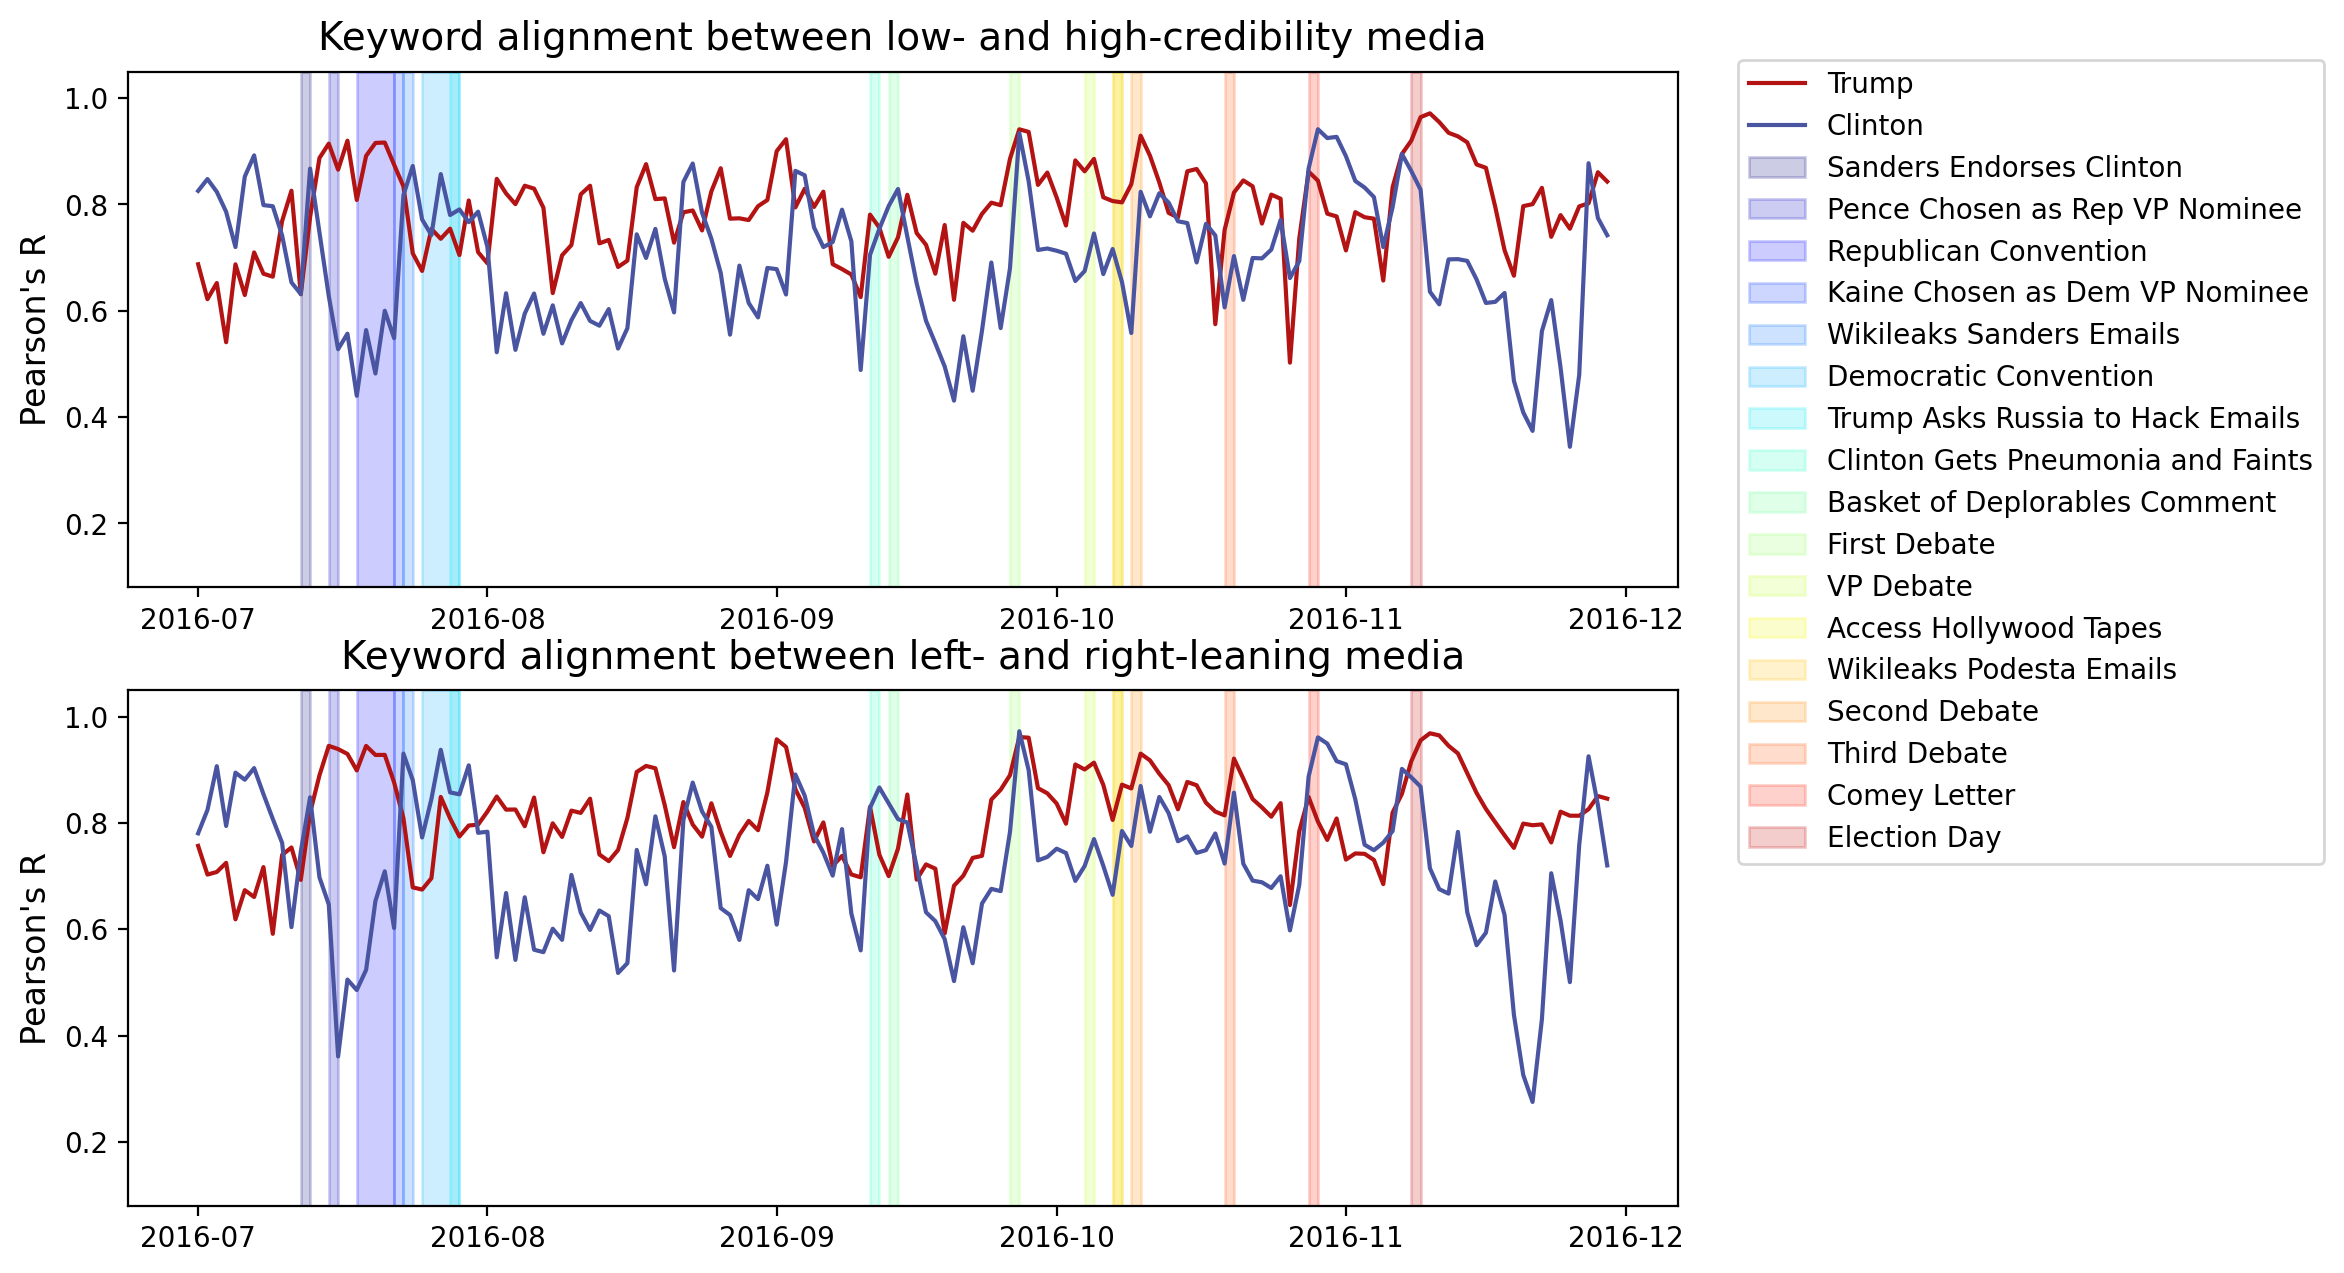

In [10]:
import matplotlib.cm as cm

dates = wordvecs_df2016["headline"][0][1]["date"].tolist()
fig, ax = plt.subplots(figsize=(10,3), nrows=2)
ax[0].plot(dates, corrs_cred1_2016, color=COLORMAP["right"], label="Trump")
ax[0].plot(dates, corrs_cred2_2016, color=COLORMAP["left"], label="Clinton")
ax[1].plot(dates, corrs_ideo1_2016, color=COLORMAP["right"], label="Trump")
ax[1].plot(dates, corrs_ideo2_2016, color=COLORMAP["left"], label="Clinton")
for i,row in events_2016.iterrows():
    ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))
    ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2016))))

for i in range(2):
    ax[i].set_ylim(.08,1.05)
    ax[i].set_ylabel("Pearson's R", fontsize=12)
# plt.ylabel("Pearson correlation", fontsize=16)
ax[0].set_title("Keyword alignment between low- and high-credibility media", fontsize=14, y=1.01)
ax[1].set_title("Keyword alignment between left- and right-leaning media", fontsize=14, y=1.01)
ax[-1].legend(bbox_to_anchor=(1.03, 2.25))
fig.subplots_adjust(top=2)
# plt.tight_layout()
plt.savefig(OUTPUT_FPATH + "tmp_word_alignment_domains2016.pdf", dpi=300, bbox_inches="tight")

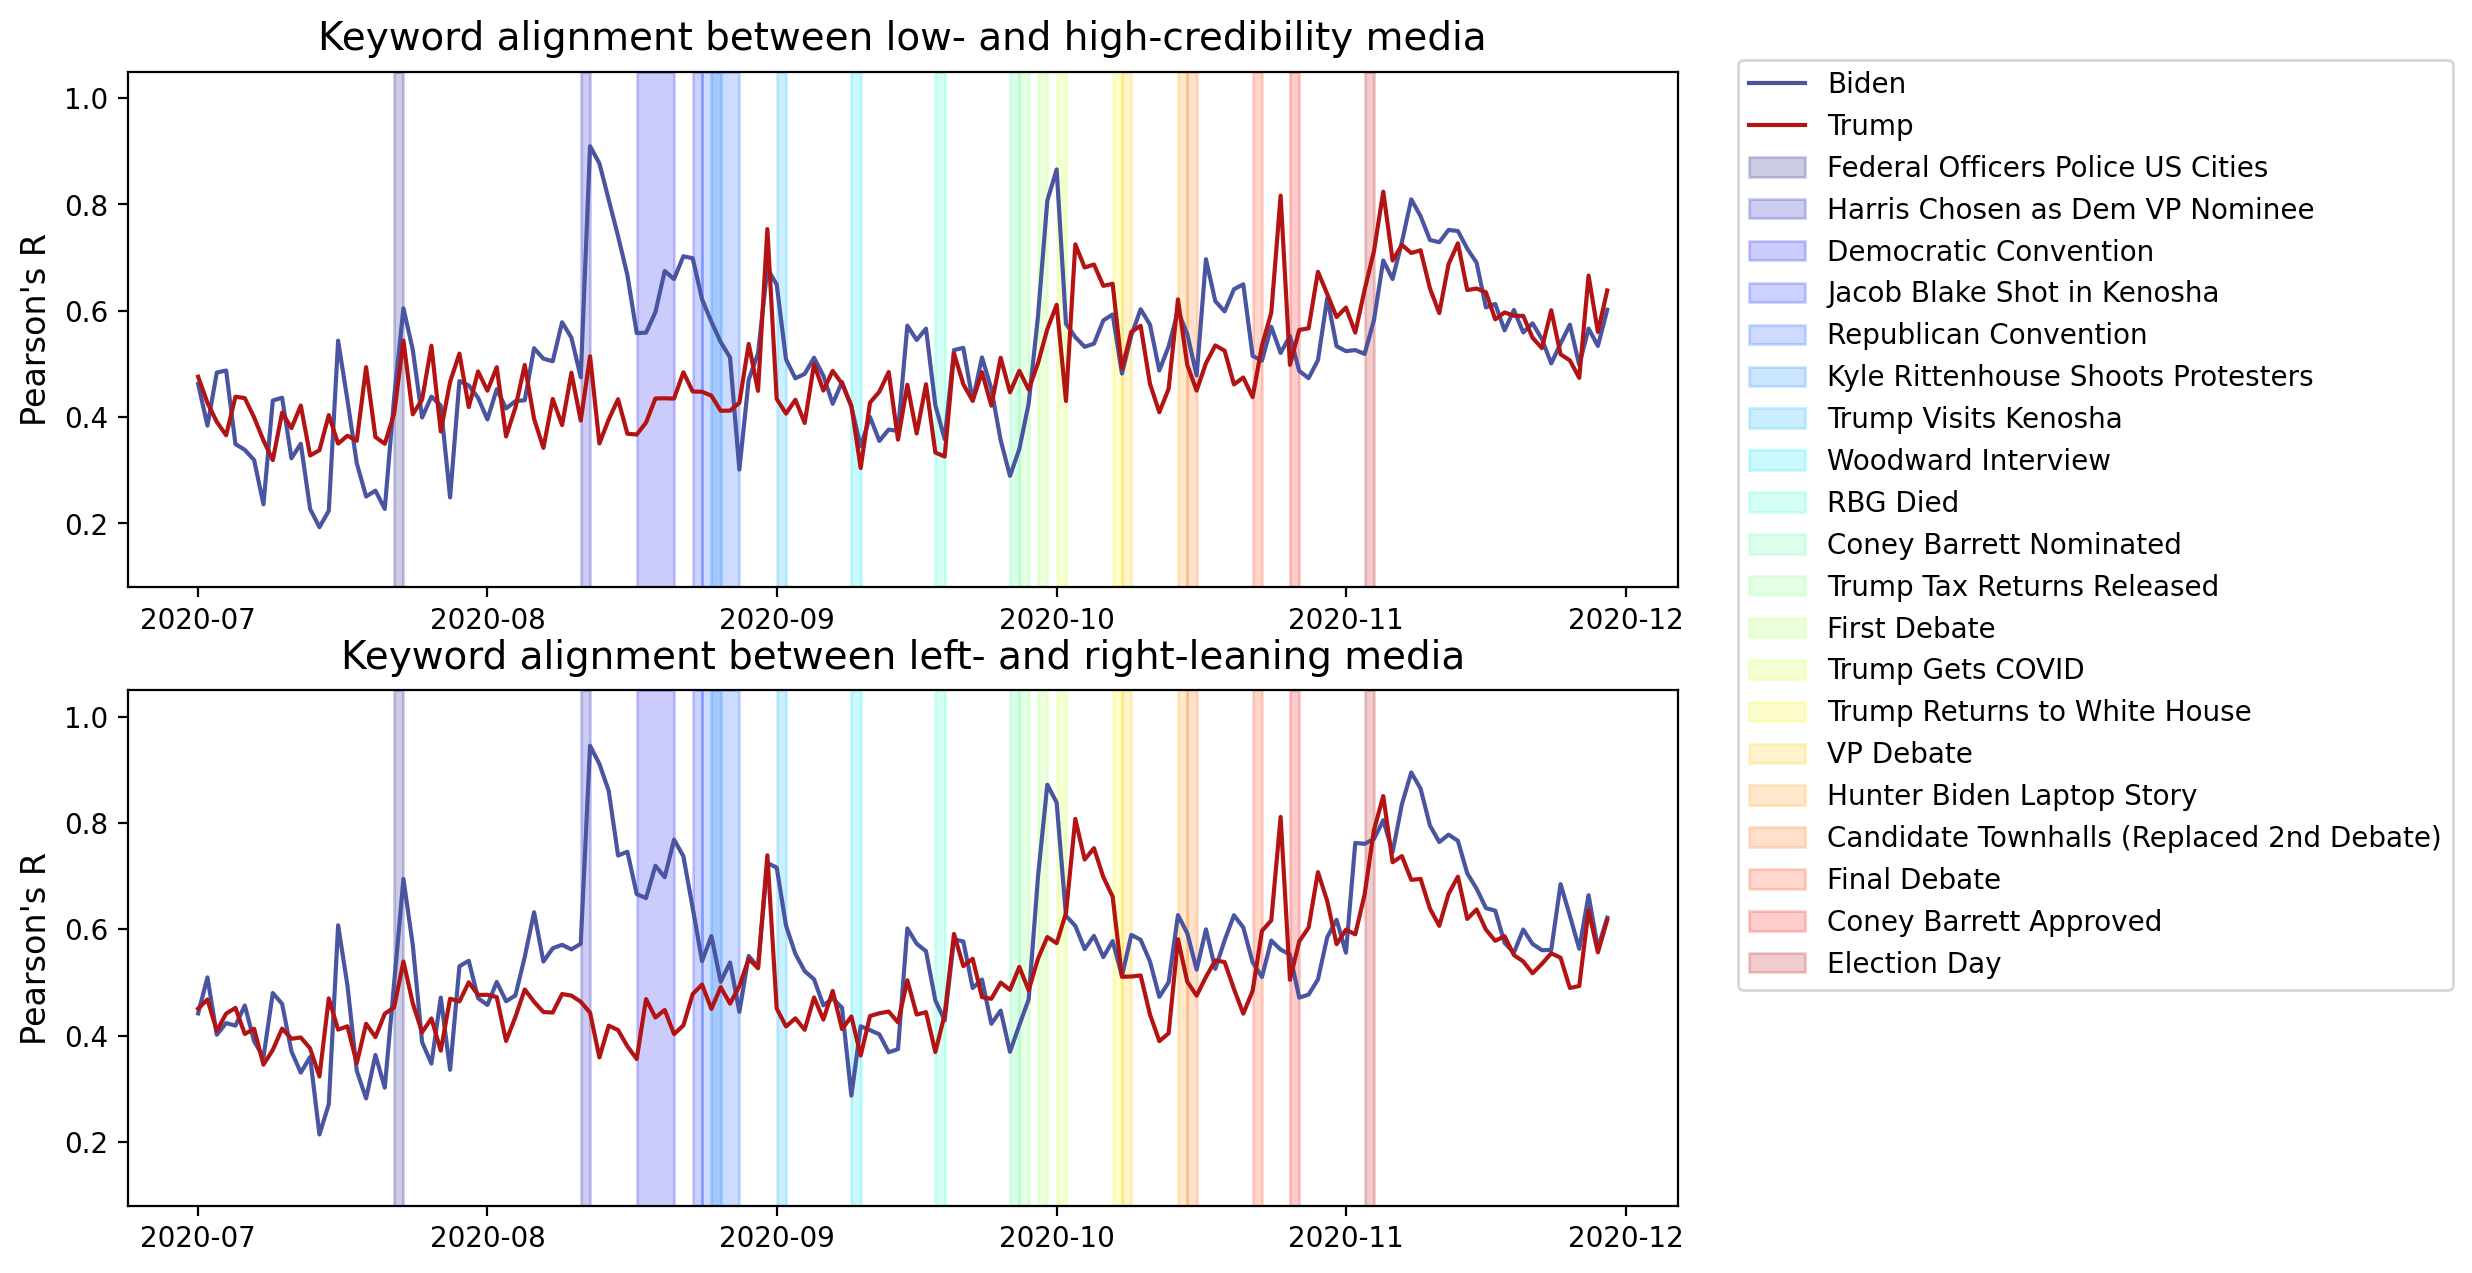

In [11]:
import matplotlib.cm as cm

dates = wordvecs_df2020["headline"][0][1]["date"].tolist()
fig, ax = plt.subplots(figsize=(10,3), nrows=2)
ax[0].plot(dates, corrs_cred1_2020, color=COLORMAP["left"], label="Biden")
ax[0].plot(dates, corrs_cred2_2020, color=COLORMAP["right"], label="Trump")
ax[1].plot(dates, corrs_ideo1_2020, color=COLORMAP["left"], label="Biden")
ax[1].plot(dates, corrs_ideo2_2020, color=COLORMAP["right"], label="Trump")
for i,row in events_2020.iterrows():
    ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))
    ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_2020))))

for i in range(2):
    ax[i].set_ylim(.08,1.05)
    ax[i].set_ylabel("Pearson's R", fontsize=12)
# plt.ylabel("Pearson correlation", fontsize=16)
ax[0].set_title("Keyword alignment between low- and high-credibility media", fontsize=14, y=1.01)
ax[1].set_title("Keyword alignment between left- and right-leaning media", fontsize=14, y=1.01)
ax[-1].legend(bbox_to_anchor=(1.03, 2.25))
fig.subplots_adjust(top=2)
# plt.tight_layout()
plt.savefig(OUTPUT_FPATH + "tmp_word_alignment_domains2020.pdf", dpi=300, bbox_inches="tight")

## Frequent keywords after certain events

In [14]:
wordvecs_df = wordvecs_df2016
dictionary = dictionary2016
topic = "clinton_controversies"
topic_keywords = dictionary.df[dictionary.df["topic"]==topic]["word"].tolist()
topic_keywords += dictionary.df[dictionary.df["topic"]=="general_controversies"]["word"].tolist()
topic_keywords_idx = [dictionary.word2index[w] for w in topic_keywords]

media_idx1 = 1 
media_idx2 = 2
cand_idx = 1
date_idx = 10
df1 = wordvecs_df["headline"][cand_idx][media_idx1]
df2 = wordvecs_df["headline"][cand_idx][media_idx2]
print("date:", df1.loc[date_idx]["date"])
wordvec_media1 = df1.loc[date_idx]["wordvec"]
wordvec_media2 = df2.loc[date_idx]["wordvec"]

print("MEDIA 1")
for k,i in enumerate(np.argsort(-wordvec_media1)[:20]):
    if i in topic_keywords_idx and wordvec_media1[i]>0:
        print(k, dictionary.index2word[i], wordvec_media1[i])
print("\n")
print("MEDIA 2")
for k,i in enumerate(np.argsort(-wordvec_media2)[:20]):
    if i in topic_keywords_idx and wordvec_media2[i]>0:
        print(k, dictionary.index2word[i], wordvec_media2[i])

date: 2016-07-11 00:00:00
MEDIA 1
0 email 24.425925925925927
1 fbi 22.425925925925924
2 classifi 12.000000000000002
3 comey 9.5
6 scandal 7.592592592592593
10 lie 5.5
14 loretta lynch 4.333333333333333
15 state dept 4.333333333333333
17 testimoni 4.0
19 investig 3.714285714285714


MEDIA 2
1 email 47.05653235653235
7 fbi 16.799221611721613
9 investig 9.610256410256408
12 classifi 9.0
14 attack 7.933333333333333
18 comey 6.583333333333334
19 clinton foundat 6.4
